In [1]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import shap

In [2]:
base_df = pd.read_csv(r'C:\Users\NickBowen\Projects\NFL Data Project\Game Data\NFL_TeamGame_Stats2024 - Sheet1.csv')

In [3]:
df = base_df.copy()

In [4]:
df.head()

,Week,Team,Opponent,Location,Stadium Type,First Downs,Rushing Attempts,Rushing Yards,Rushing Touchdowns,Passing Completions,...,Total 3rd Down Attempts,Total 3rd Down Completions,3rd Down Conversion,Total 4th Down Attempts,Total 4th Down Completions,4th Down Conversion,Time of Possesion,Points,Opponent Points,Win/Loss
0,1,Ravens,Chiefs,Away,Outdoor,25,32,185,1,26,...,14,7,0.500000,2,1,0.5,33:43:00,20,27,Loss
1,1,Chiefs,Ravens,Home,Outdoor,21,20,72,2,20,...,9,4,0.444444,0,0,NaN,26:17:00,27,20,Win
2,1,Packers,Eagles,Home,International,19,21,163,1,17,...,11,3,0.272727,1,1,1.0,27:13:00,29,34,Loss
3,1,Eagles,Packers,Away,International,25,38,144,2,20,...,14,4,0.285714,1,1,1.0,32:47:00,34,29,Win
4,1,Steelers,Falcons,Away,Indoor,16,41,137,0,17,...,17,8,0.470588,1,0,0.0,35:36:00,18,10,Win


In [5]:
print(df.columns)

Index(['Week', 'Team', 'Opponent', 'Location', 'Stadium Type', 'First Downs',
       'Rushing Attempts', 'Rushing Yards', 'Rushing Touchdowns',
       'Passing Completions', 'Passing Attempts', 'Passing Yards',
       'Passing Touchdowns', 'Interceptions', 'Total Sacks',
       'Total Sack Yards', 'Total Fumbles', 'Total Fumbles Lost', 'Turnovers',
       'Total Penalties', 'Total Penalty Yards', 'Total 3rd Down Attempts',
       'Total 3rd Down Completions', '3rd Down Conversion',
       'Total 4th Down Attempts', 'Total 4th Down Completions',
       '4th Down Conversion', 'Time of Possesion', 'Points', 'Opponent Points',
       'Win/Loss'],
      dtype='object')


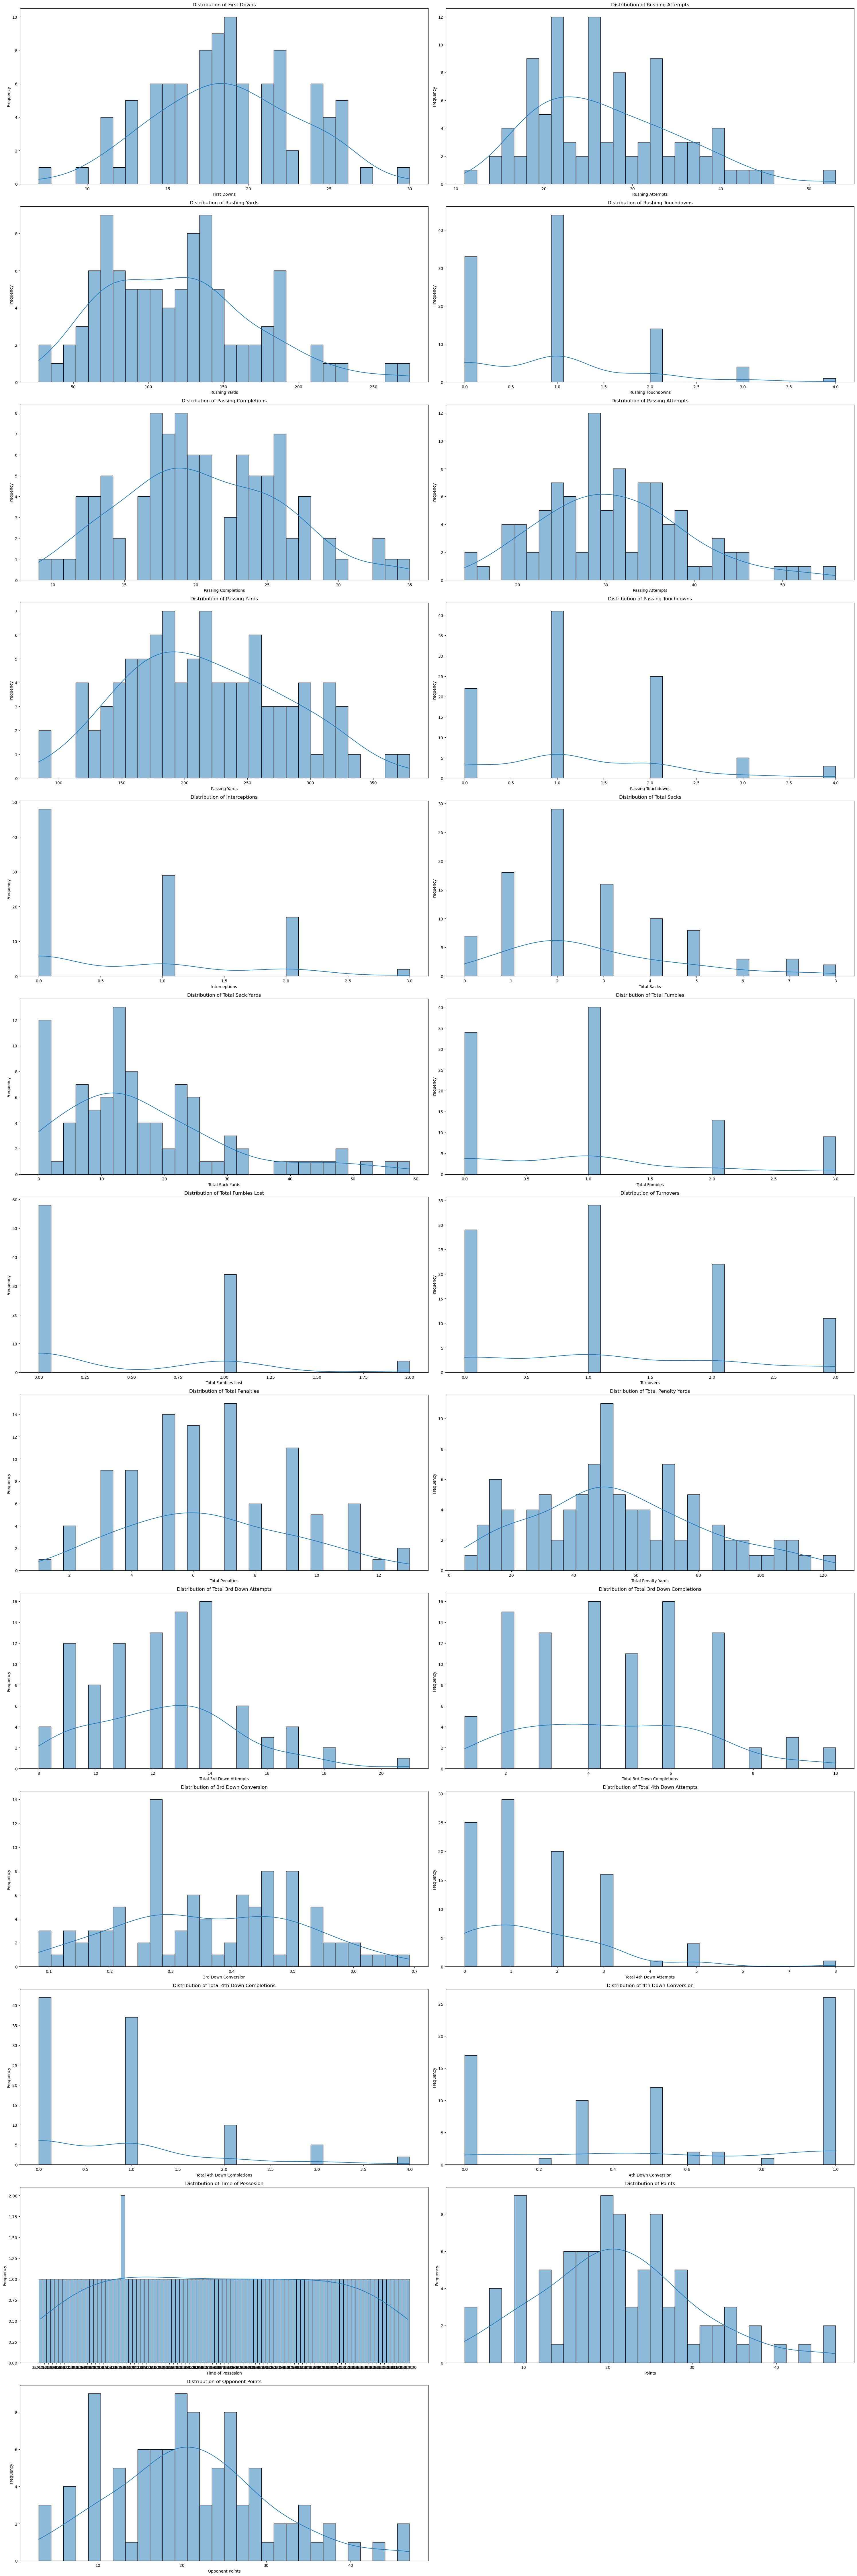

In [6]:
# loop that shows distribution of each column

drop_cols = ['Week','Team','Opponent','Location','Stadium Type','Win/Loss']

plot_cols = df.columns[~df.columns.isin(drop_cols)]

num_plots = len(plot_cols)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 2, figsize=(30, 90))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, column in enumerate(plot_cols):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])  # Plot histogram with KDE
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_aspect(aspect='auto')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

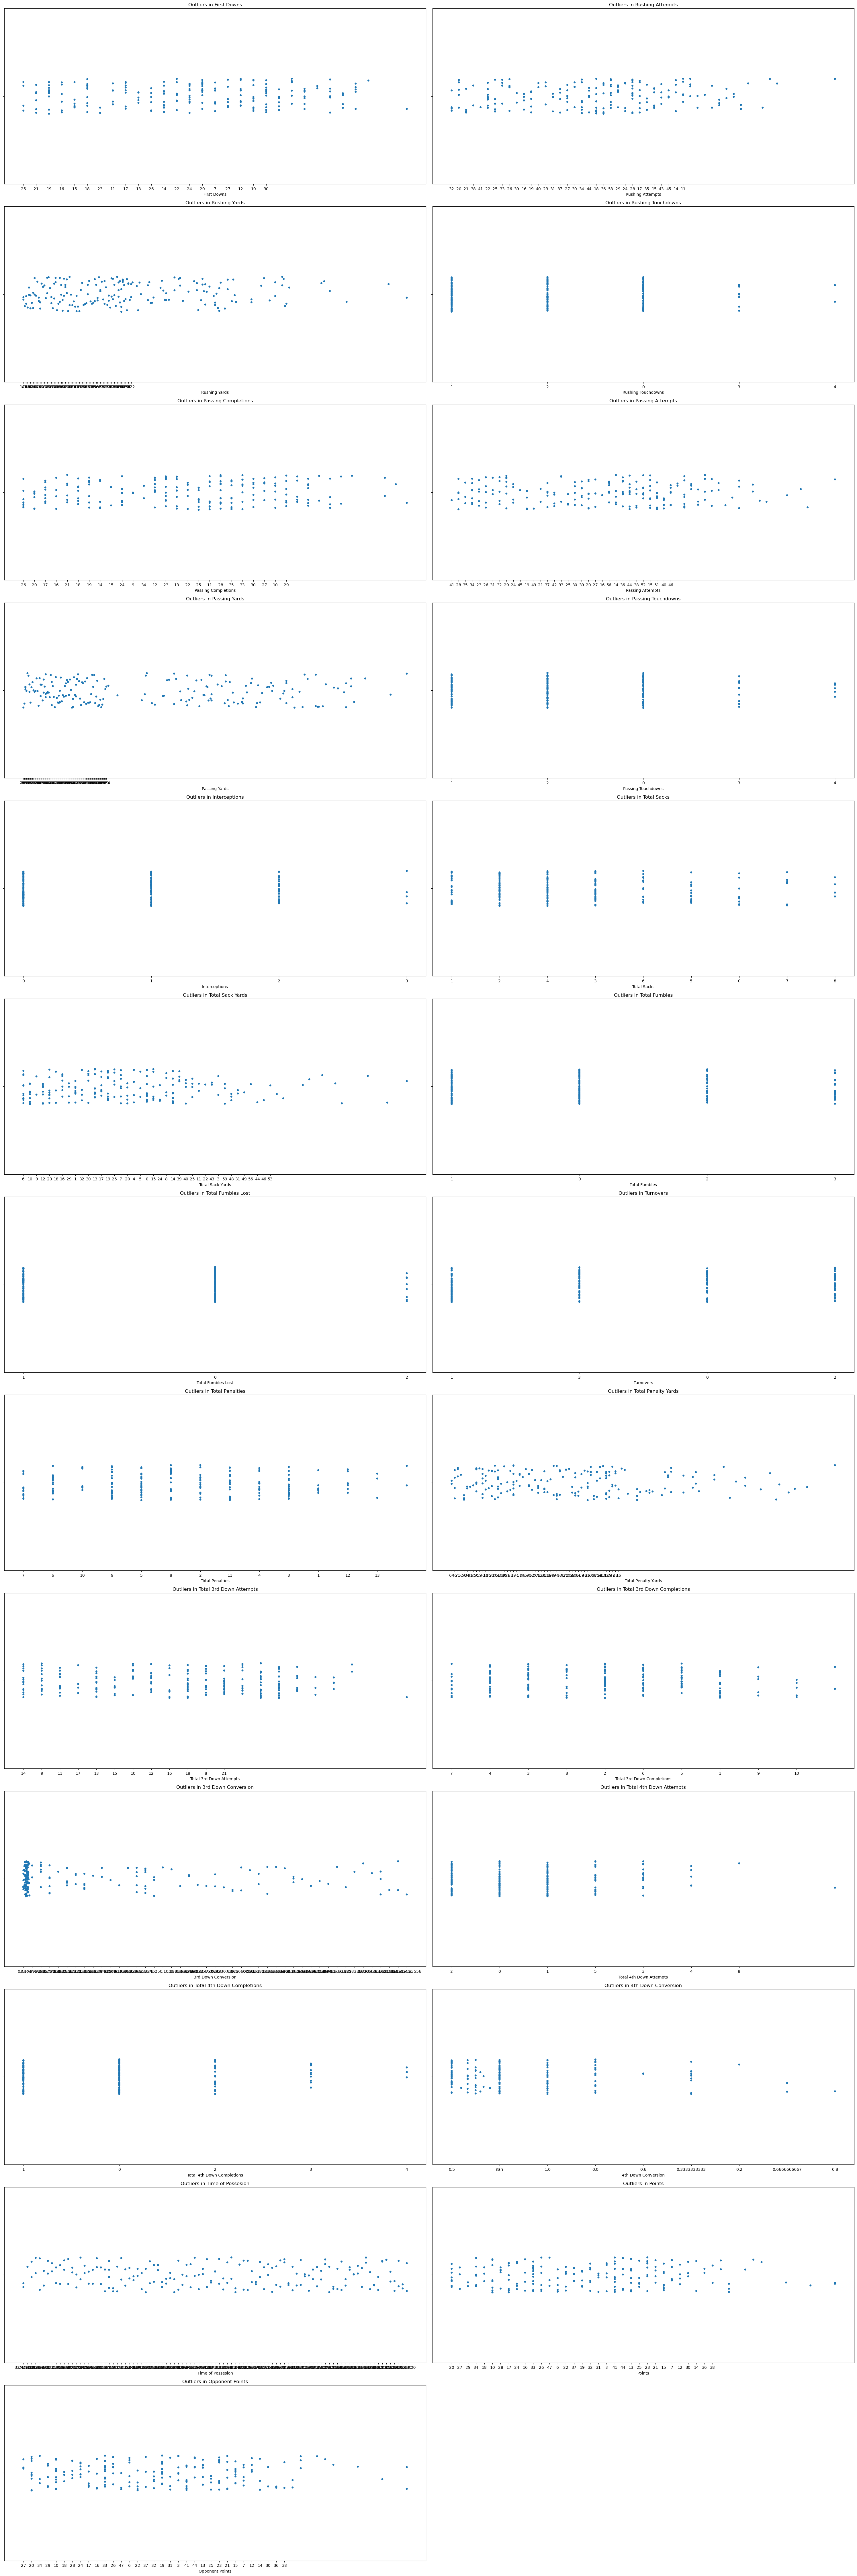

In [7]:
# loop that shows the outliers in each column

drop_cols = ['Week','Team','Opponent','Location','Stadium Type','Win/Loss']

plot_cols = df.columns[~df.columns.isin(drop_cols)]

num_plots = len(plot_cols)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 2, figsize=(30, 90))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, column in enumerate(plot_cols):
    # Convert float values to strings for plotting
    sns.stripplot(x=df[column].astype(str), ax=axes[i], jitter=True)  # Create dot plot
    sns.stripplot(x=df[column], ax=axes[i], jitter=True)  # Create dot plot
    axes[i].set_title(f'Outliers in {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
df.dtypes

Week                            int64
Team                           object
Opponent                       object
Location                       object
Stadium Type                   object
First Downs                     int64
Rushing Attempts                int64
Rushing Yards                   int64
Rushing Touchdowns              int64
Passing Completions             int64
Passing Attempts                int64
Passing Yards                   int64
Passing Touchdowns              int64
Interceptions                   int64
Total Sacks                     int64
Total Sack Yards                int64
Total Fumbles                   int64
Total Fumbles Lost              int64
Turnovers                       int64
Total Penalties                 int64
Total Penalty Yards             int64
Total 3rd Down Attempts         int64
Total 3rd Down Completions      int64
3rd Down Conversion           float64
Total 4th Down Attempts         int64
Total 4th Down Completions      int64
4th Down Con

In [9]:
# Loop through the columns and check data types
for column in df.columns:
    # Get the unique data types in the column
    unique_dtypes = df[column].apply(type).unique()
    
    # Check if there are multiple data types
    if len(unique_dtypes) > 1:
        print(f"Column '{column}' has multiple data types: {unique_dtypes}")

In [10]:
# Split the data into features and target
X = df.drop(['Points','Week','Win/Loss','Opponent Points','Opponent','Team'], axis=1)
y = df['Points']

In [11]:
#defining categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Create a column transformer for one-hot encoding and imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Ignore unknown categories
        ]), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['float64', 'int64']).columns)  # Impute missing values with the mean for numerical columns
    ],
    remainder='passthrough'  # Keep the rest of the columns unchanged
)

In [14]:
# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))
])

In [15]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Location', 'Stadium Type',
                                                   'Time of Possesion']),
                                                 ('num', SimpleImputer(),
                                                  Index(['First Downs', 'Rushing Attempts', 'Rushing Yards',...
       'Passing Yards', 'Passing Touchdown

In [16]:
# Optionally, make predictions
y_pred = pipeline.predict(X_test)

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [17]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 3.964834591873584
Mean Squared Error (MSE): 26.956787155608346
R-squared (R²): 0.6500368419641253


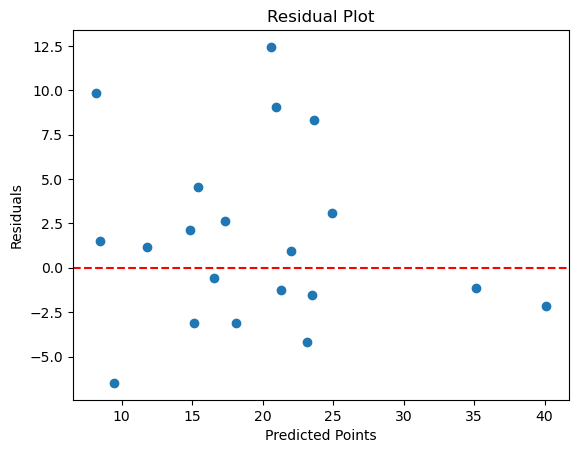

In [18]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Points')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

**Running feature importance, Shap Analysis**

In [29]:


# Extract coefficients from the trained Ridge model
coefficients = pipeline.named_steps['model'].coef_

# If you want to pair the coefficients with feature names
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
all_feature_names = np.concatenate([onehot_columns, numeric_columns])
feature_importances = dict(zip(all_feature_names, coefficients))


In [31]:

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])


In [32]:
# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

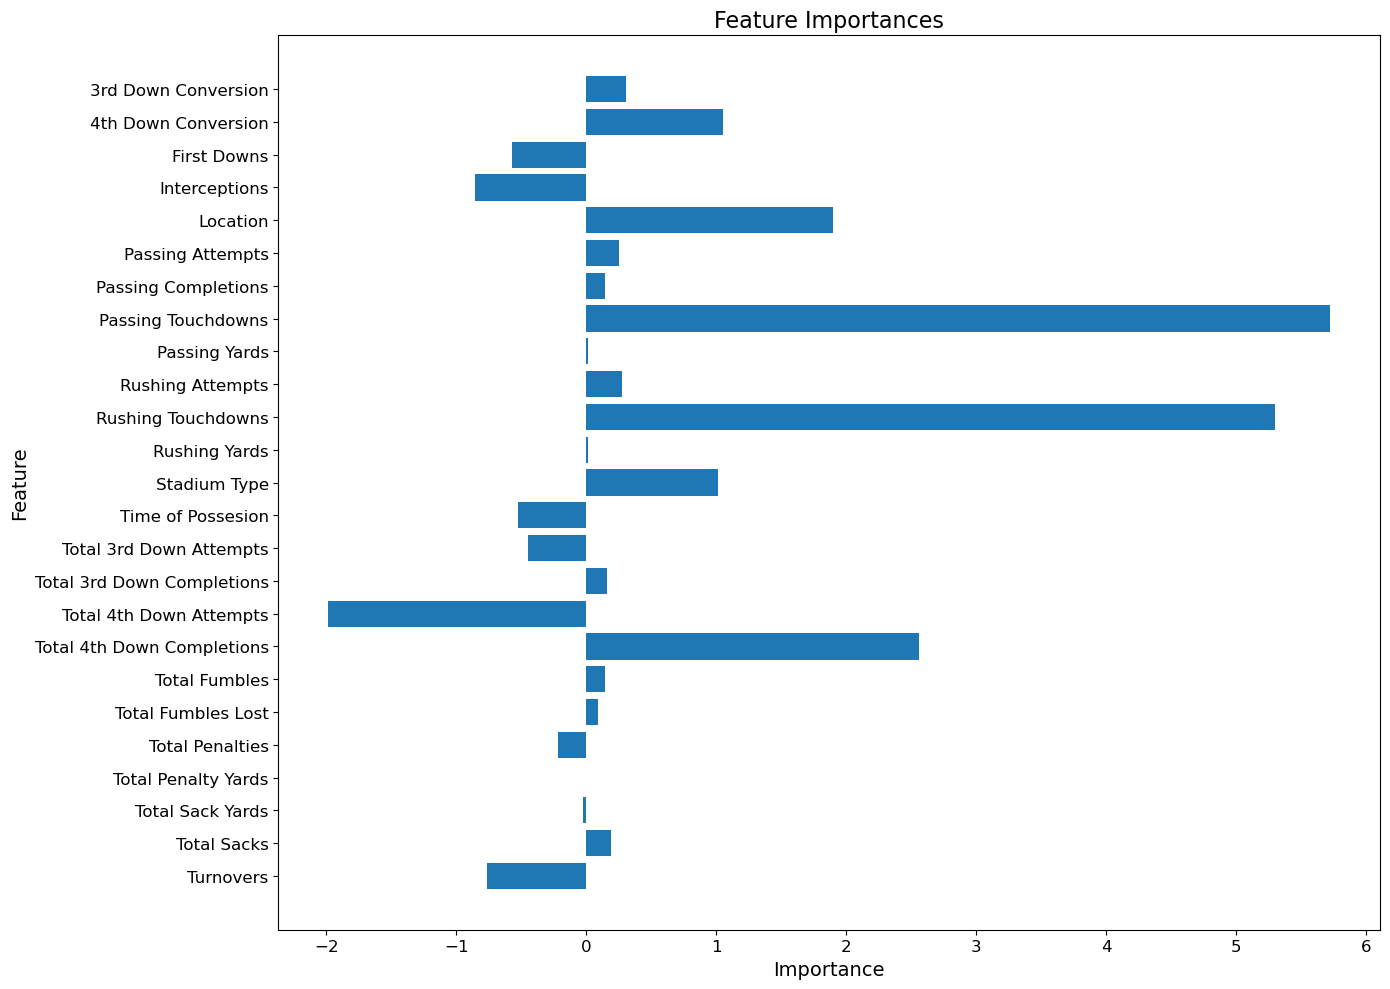

Least impactful features:
                       Feature  Importance
15  Total 3rd Down Completions    0.160141
16     Total 4th Down Attempts   -1.984087
17  Total 4th Down Completions    2.561295
18               Total Fumbles    0.139775
19          Total Fumbles Lost    0.091023
20             Total Penalties   -0.216147
21         Total Penalty Yards    0.000553
22            Total Sack Yards   -0.029621
23                 Total Sacks    0.192332
24                   Turnovers   -0.762195


In [62]:
# Sort the aggregated importances by 'Importance' in descending order
aggregated_importances = aggregated_importances.sort_values(by='Importance', ascending=False)

# Aggregate feature importances for one-hot encoded features
aggregated_importances = feature_importance_df.groupby(feature_importance_df['Feature'].str.split('_').str[0]).sum().reset_index()

# Plot the feature importances with adjusted figure size and font size
plt.figure(figsize=(14, 10))  # Increase the figure size
plt.barh(aggregated_importances['Feature'], aggregated_importances['Importance'])
plt.xlabel('Importance', fontsize=14)  # Increase font size for x-axis label
plt.ylabel('Feature', fontsize=14)  # Increase font size for y-axis label
plt.title('Feature Importances', fontsize=16)  # Increase font size for title
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)  # Increase font size for x-axis ticks
plt.yticks(fontsize=12)  # Increase font size for y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Display the least impactful features
print("Least impactful features:")
print(aggregated_importances.tail(10))




**Visualizing the difference in predicted value vs actual value**

In [68]:
# Ensure all columns from the original dataframe are included in the results DataFrame
results_df = base_df.loc[X_test.index].copy()

# Make predictions
y_pred = pipeline.predict(X_test)

# Add the actual and predicted values to the results DataFrame
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# Ensure 'Team' and 'Opponent' columns are included
results_df = results_df[['Team', 'Opponent', 'Actual', 'Predicted', 'Difference'] + [col for col in results_df.columns if col not in ['Team', 'Opponent', 'Actual', 'Predicted', 'Difference']]]

# Display the first few rows of the results DataFrame
results_df.head()

# Create a DataFrame with the actual and predicted values
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# Display the first few rows of the results DataFrame
results_df.head()

results_df.to_csv('results.csv', index=False)

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


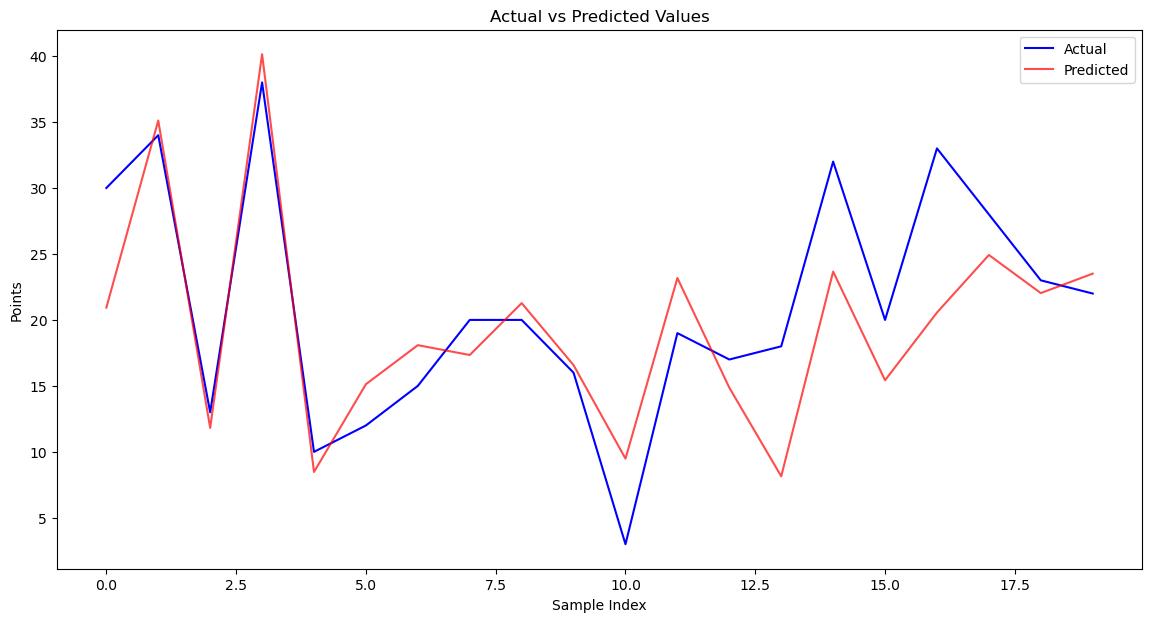

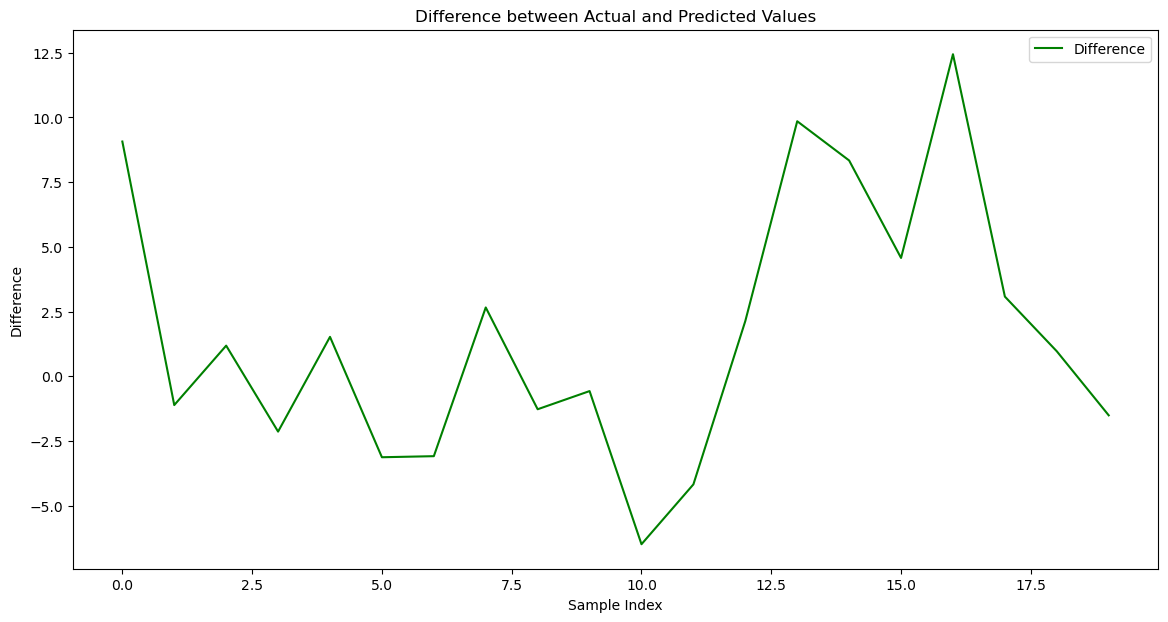

In [66]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(results_df['Actual'].values, label='Actual', color='blue')
plt.plot(results_df['Predicted'].values, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Points')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Plot the differences
plt.figure(figsize=(14, 7))
plt.plot(results_df['Difference'].values, label='Difference', color='green')
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Values')
plt.legend()
plt.show()

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


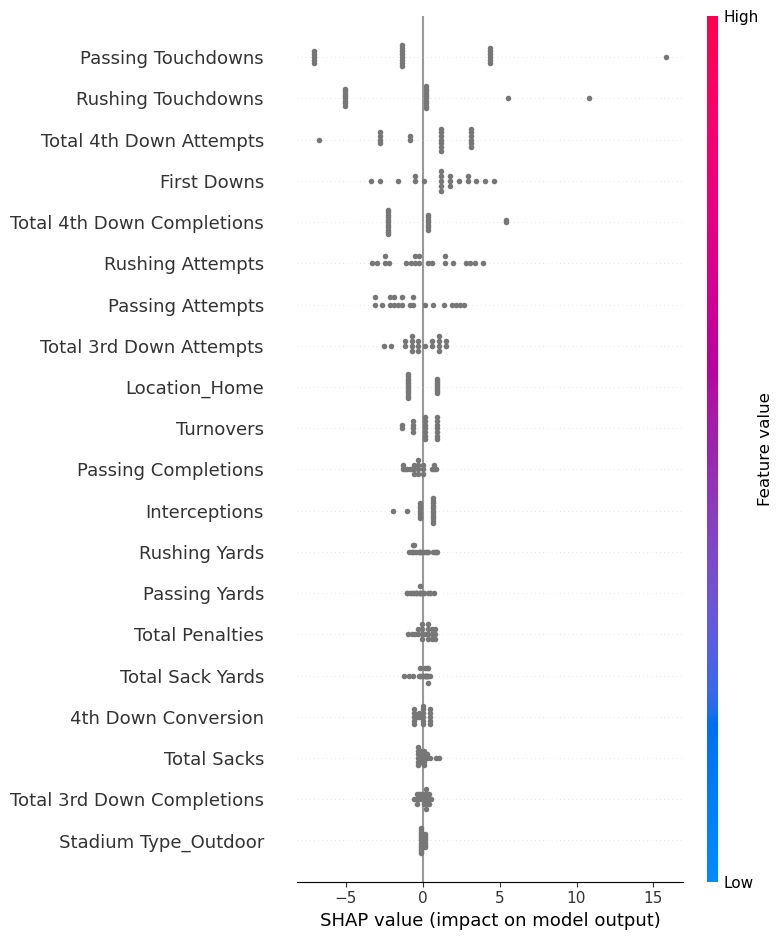

In [72]:
# Create a SHAP explainer
explainer = shap.Explainer(pipeline.named_steps['model'], pipeline.named_steps['preprocessor'].transform(X_train), feature_names=all_feature_names)

# Calculate SHAP values for the test set
shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X_test))

# Plot the SHAP summary plot with color scale
shap.summary_plot(shap_values, features=pipeline.named_steps['preprocessor'].transform(X_test), feature_names=all_feature_names, plot_type="dot", color=shap.Explanation.abs.shap_values)